# Example: Static inverse free-boundary equilibrium calculations (in ITER)

---

Here we will generate an equilibrium (find coil currents with the inverse solver) in an ITER-like tokamak. 

The machine description comes from files located [here](https://github.com/ProjectTorreyPines/FUSE.jl).

The equilbirium\profile parameters are **completely made up** - please experiment on your own and change them to more realistic values as you please!

### Import packages

In [1]:
import os
import matplotlib.pyplot as plt
import freegs4e
import numpy as np

### Create the machine object

In [2]:
# set paths
os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/ITER/ITER_active_coils.pickle"
os.environ["PASSIVE_COILS_PATH"] = f"../machine_configs/ITER/ITER_passive_coils.pickle"
os.environ["WALL_PATH"] = f"../machine_configs/ITER/ITER_wall.pickle"
os.environ["LIMITER_PATH"] = f"../machine_configs/ITER/ITER_limiter.pickle"

In [3]:
# Now the machine can actually be built:
from freegsnke import build_machine
tokamak = build_machine.tokamak()

No coil named Solenoid among the active coils.
No probe configuration is provided


Text(60.291666666666664, 0.5, 'Height, $Z$ [m]')

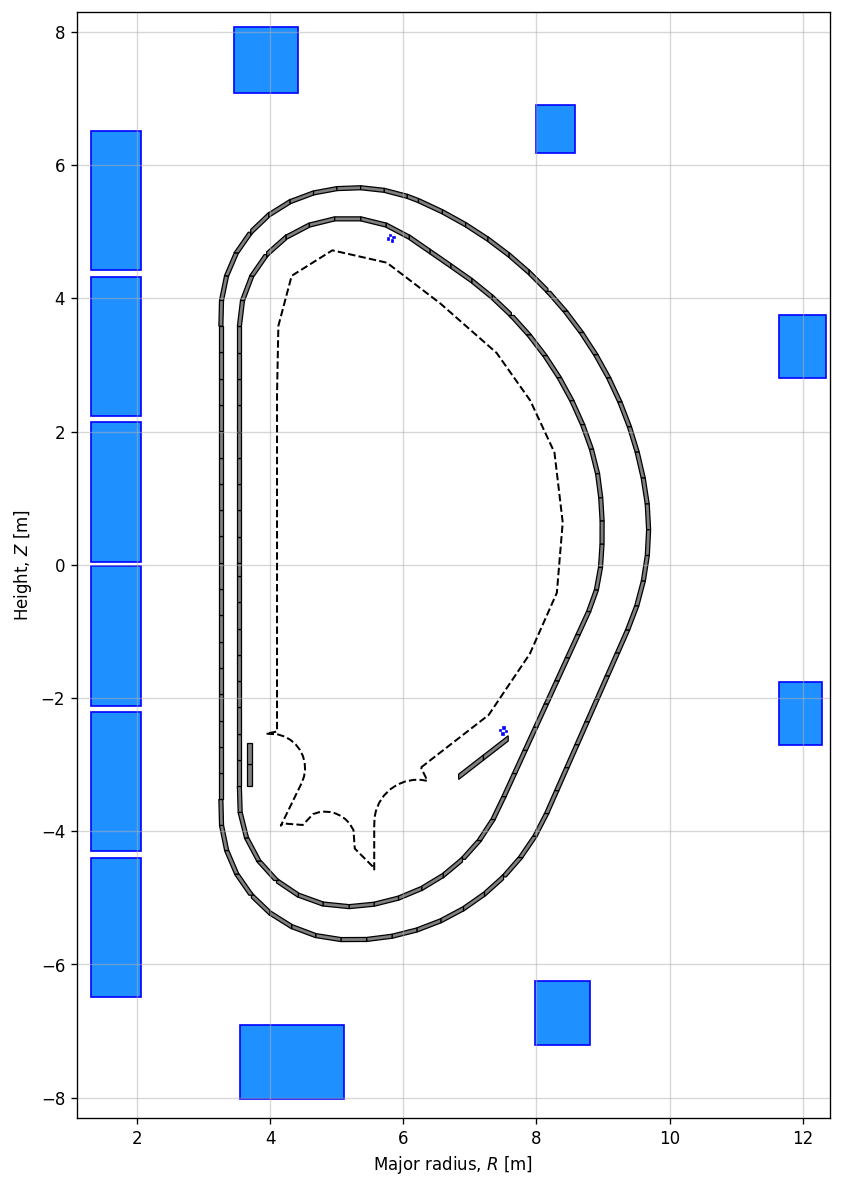

In [4]:
# plot the machine
fig1, ax1 = plt.subplots(1, 1, figsize=(7, 15), dpi=120)
plt.tight_layout()

tokamak.plot(axis=ax1, show=False)
ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
# ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")

ax1.grid(alpha=0.5)
ax1.set_aspect('equal')
ax1.set_xlim(1.1, 12.4)
ax1.set_ylim(-8.3, 8.3)
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')

### Instantiate an equilibrium

In [5]:
from freegsnke import equilibrium_update

eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,       # provide tokamak object
    Rmin=2.6, Rmax=10,   # radial range
    Zmin=-6, Zmax=6,   # vertical range
    nx=129,                # number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,                # number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)

### Instantiate a profile object

In [6]:
# initialise the profiles
from freegsnke.jtor_update import ConstrainBetapIp
profiles = ConstrainBetapIp(
    eq=eq,        # equilibrium object
    betap=0.1,   # poloidal beta
    Ip=11e6,      # plasma current
    fvac=0.5,     # fvac = rB_{tor}
    alpha_m=2.0,  # profile function parameter
    alpha_n=1.0   # profile function parameter
)

### Load the static nonlinear solver

In [7]:
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

### Constraints

In [8]:
import freegs4e

# set X-point locations
Rx = 4.93
Zx = -3.36
xpoints = [(Rx, Zx)]

# set any desired isoflux constraints with format (R1, Z1, R2, Z2), where (R1, Z1) and (R2, Z2) are 
# desired to be on the same flux contour.
isoflux = [
(Rx, Zx, 4.0228038405382+0.2, 0.5483452102114228),
# (Rx, Zx, 4.89677909,	-0.482538815),
(Rx, Zx, 4.254412439959347+0.1,	-1.448212877),
# (Rx, Zx, 4.557724156077329,	-2.43093497),
# (Rx, Zx, 6.225706428928894,	-2.841131482),
(Rx, Zx, 7.259463335861366,	-1.937088788),
(Rx, Zx, 7.911539671975528,	-0.767136564),
(Rx, Zx, 8.145511203289532,	 0.5532657790590028),
(Rx, Zx, 7.465729748693425,	 2.551811974626763),
(Rx, Zx, 6.052665521315404,	 3.743583690053864),
(Rx, Zx, 4.845816114370034,	3.779966078),
(Rx, Zx, 4.176404732054874+0.1,	 2.503053610591648),
]



           
# instantiate the constrain object
constrain = freegs4e.control.constrain(xpoints=xpoints,
                                         isoflux=isoflux,
                                       # psivals=psivals, # not used
                                         gamma=1e-12       # regularisation factor
                                         )

### The inverse solve

In [10]:
# re-normalise the plasma flux -- default peak is 1
eq.plasma_psi *= 20
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-6,
                     verbose=True, # print output
                     picard=True, 
                     )

Dicrepancy between psi_func and plasma_psi detected. psi_func has been re-set.


(-8.3, 8.3)

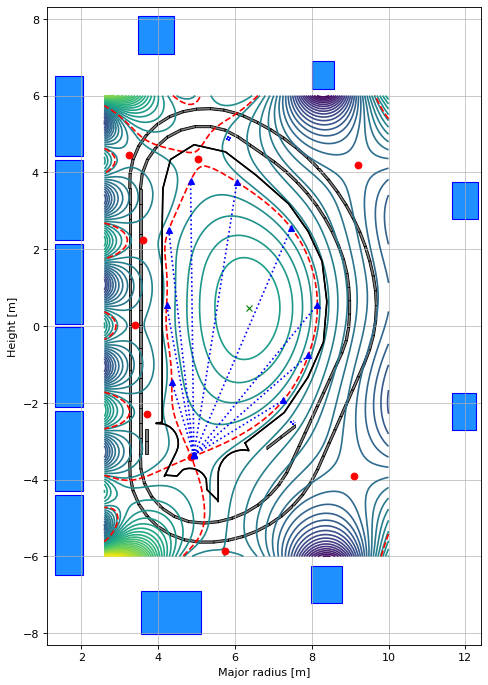

In [11]:
fig1, ax1 = plt.subplots(1, 1, figsize=(7, 15), dpi=80)

ax1.grid(zorder=0, alpha=0.75)
ax1.set_aspect('equal')
eq.tokamak.plot(axis=ax1,show=False)                                                          # plots the active coils and passive structures
ax1.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter
eq.plot(axis=ax1,show=False)                                                                  # plots the equilibrium
constrain.plot(axis=ax1, show=False)                                                          # plots the contraints
ax1.set_xlim(1.1, 12.4)
ax1.set_ylim(-8.3, 8.3)


In [12]:
eq.tokamak.getCurrents()

# # save coil currents to file
# import pickle
# with open('simple_diverted_currents_PaxisIp.pk', 'wb') as f:
#     pickle.dump(obj=inverse_current_values, file=f)

{'CS1': -539936811.174986,
 'CS2': -516560402.4733338,
 'CS3': -663096974.6060972,
 'VS3': 5412.304634791014,
 'PF1': -145800143.3621292,
 'PF2': -25895926.01722572,
 'PF3': -12970189.352853963,
 'PF4': -13517861.818832908,
 'PF5': -28622713.25529466,
 'PF6': -118980416.95981608,
 'I1_0': 0,
 'I2_0': 0,
 'I3_0': 0,
 'I4_0': 0,
 'I5_0': 0,
 'I6_0': 0,
 'I7_0': 0,
 'I8_0': 0,
 'I9_0': 0,
 'I10_0': 0,
 'I11_0': 0,
 'I12_0': 0,
 'I13_0': 0,
 'I14_0': 0,
 'I15_0': 0,
 'I16_0': 0,
 'I17_0': 0,
 'I18_0': 0,
 'I19_0': 0,
 'I20_0': 0,
 'I21_0': 0,
 'I22_0': 0,
 'I23_0': 0,
 'I24_0': 0,
 'I25_0': 0,
 'I26_0': 0,
 'I27_0': 0,
 'I28_0': 0,
 'I29_0': 0,
 'I30_0': 0,
 'I31_0': 0,
 'I32_0': 0,
 'I33_0': 0,
 'I34_0': 0,
 'I35_0': 0,
 'I36_0': 0,
 'I37_0': 0,
 'I38_0': 0,
 'I39_0': 0,
 'I40_0': 0,
 'I41_0': 0,
 'I42_0': 0,
 'I43_0': 0,
 'I44_0': 0,
 'I45_0': 0,
 'I46_0': 0,
 'I47_0': 0,
 'I48_0': 0,
 'I49_0': 0,
 'I50_0': 0,
 'I51_0': 0,
 'I52_0': 0,
 'I53_0': 0,
 'I54_0': 0,
 'I55_0': 0,
 'I56_0': 0,
